In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
# for dataset
import zipfile
import tarfile
import shutil
import os
import pandas as pd
# Use GPU or CPU for training
device = ("cuda" if torch.cuda.is_available() else "cpu") 

In [ ]:
class AlexNet(nn.Module):
    
    def __init__(self, num_classes: int = 2):
        super(AlexNet, self).__init__()

        self.convolutional = nn.Sequential(
            # first layer
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            # activation function
            nn.ReLU(inplace=True),
            # pooling
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.linear = nn.Sequential(
            nn.Dropout(),
            # fully connected layer
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, 2) # 2 classes
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.convolutional(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return torch.softmax(x, 1)


In [ ]:
model = AlexNet()

In [ ]:
!mkdir COMP3340

In [ ]:
!cd COMP3340

In [ ]:
!mkdir dataset

In [ ]:
%cd dataset

/content/COMP3340/dataset


In [ ]:
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2022-10-14 07:35:27--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.192.48
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.192.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  41.1MB/s    in 35s     

2022-10-14 07:36:03 (39.3 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [ ]:
!wget https://zenodo.org/record/2536630/files/Tiny-ImageNet-C.tar

--2022-10-14 08:30:05--  https://zenodo.org/record/2536630/files/Tiny-ImageNet-C.tar
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1794775040 (1.7G) [application/octet-stream]
Saving to: ‘Tiny-ImageNet-C.tar’

Tiny-ImageNet-C.tar 100%[===================>]   1.67G  28.7MB/s    in 2m 48s  

2022-10-14 08:32:55 (10.2 MB/s) - ‘Tiny-ImageNet-C.tar’ saved [1794775040/1794775040]



In [ ]:
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [ ]:
with tarfile.TarFile("Tiny-ImageNet-C.tar","r") as tar_ref:
  tar_ref.extractall("data_c/")

In [ ]:
!rmdir data_c

rmdir: failed to remove 'data_c': Directory not empty


In [ ]:
root = 'data_faces/img_align_celeba'
# store names of images
img_list = os.listdir(root)
print(len(img_list))

202599


In [ ]:
# data frame
df = pd.read_csv("list_attr_celeba.csv")
# attribute for our images
df = df[['image_id', 'Smiling']] 

In [ ]:
!mkdir smile

In [ ]:
!mkdir no_smile

In [ ]:
s0 = 0
s1 = 0

num = 1500

for i, (_, i_row) in enumerate(df.iterrows()):
  if s0 < num:
    if i_row['Smiling'] == 1:
      s0 += 1
      shutil.copyfile('data_faces/img_align_celeba/' + i_row['image_id'], 'smile/' + i_row['image_id'])
  
  if s1 < num:
    if i_row['Smiling'] == -1:
      s1 += 1
      shutil.copyfile('data_faces/img_align_celeba/' + i_row['image_id'], 'no_smile/' + i_row['image_id'])
  
  if s0 == num and s1 == num:
    break

In [ ]:
img_list = os.listdir('smile/')
img_list.extend(os.listdir('no_smile/'))
print("Images: ", len(img_list))

Images:  3000


In [ ]:
transform = transforms.Compose([
          transforms.Resize((64, 64)),
          transforms.ToTensor()
          ])

batch_size = 64
celeba_data = datasets.ImageFolder('data', transform=transform)

In [ ]:
print(celeba_data.classes)
print(len(celeba_data))

['no_smile', 'smile']
3000


In [ ]:
# split dataset
# 75% training, 15% testing
train_set, test_set = torch.utils.data.random_split(celeba_data, [int(len(img_list) * 0.75), len(img_list) - int(len(img_list) * 0.75)])
train_data_size = len(train_set)
test_data_size = len(test_set)

In [ ]:
print(train_data_size)
print(test_data_size)

2250
750


In [ ]:
# add dataloader
trainLoader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
testLoader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [ ]:
optimizer = optim.Adam(model().parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 10
train_loss = []

for epoch in range(epochs):
   
    total_train_loss = 0
    
    # training our model
    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    print(f'Epoch: {epoch} | Train Loss: {total_train_loss}')

Epoch: 0 | Train Loss: 0.693119678232405
Epoch: 1 | Train Loss: 0.6931037389569812
Epoch: 2 | Train Loss: 0.6931147426366806
Epoch: 3 | Train Loss: 0.6931716733508639
Epoch: 4 | Train Loss: 0.6932007206810845
Epoch: 5 | Train Loss: 0.6931490732563866
Epoch: 6 | Train Loss: 0.6931207842297025
Epoch: 7 | Train Loss: 0.6931753506263097
Epoch: 8 | Train Loss: 0.6932412402497398
Epoch: 9 | Train Loss: 0.6931367665529251


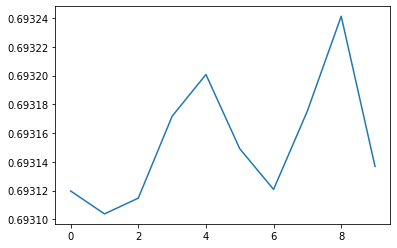

In [ ]:
plt.plot(train_loss)

In [ ]:
testiter = iter(testLoader)
images, labels = testiter.next()


In [ ]:
with torch.no_grad():
  # images = images.to(device) 
  # labels = labels.to(device)
  pred = model(images)

print(pred.shape)

torch.Size([64, 2])


In [ ]:
images_np = [i.cpu() for i in images]
class_names = celeba_data.classes
print(class_names)

['no_smile', 'smile']


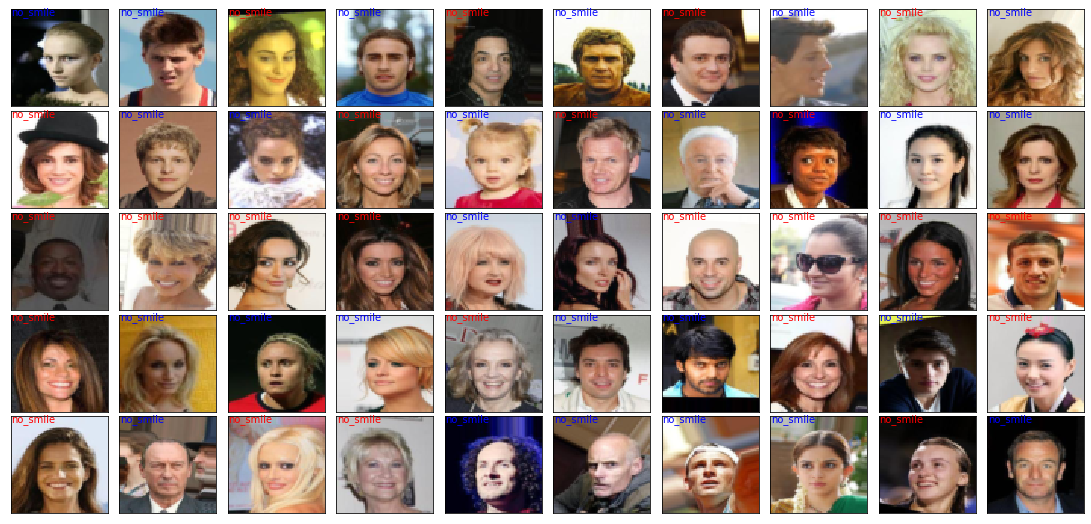

In [ ]:
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i].permute(1, 2, 0), cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[i] == torch.max(pred[i], 0)[1]:
      ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='blue')
    else:
      ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='red')